In [1]:
import IPython
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *

2021-08-27 17:00:32.663119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
## PRUEBAS ## 


In [10]:
CARPETA = '/home/martin/deep-dereverb/model/ckpts/aug/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
PESOS = pesos[9]
modelo = autoencoder()
modelo.load_weights(PESOS)

In [11]:
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/train/aug/')
clean_list = get_audio_list('/home/martin/deep-dereverb/data/train/clean/')
reverb_list.sort(); clean_list.sort()

In [12]:
audio_in, fs = librosa.load(reverb_list[570], sr=None)
audio_target, fs = librosa.load(clean_list[570], sr=None)
espectro_in, arr_min, arr_max = gen_stft(audio_in)
espectro_target, arr_mint, arr_maxt = gen_stft(audio_target)

In [13]:
espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
espectro_out = espectro_out.reshape(256,256)

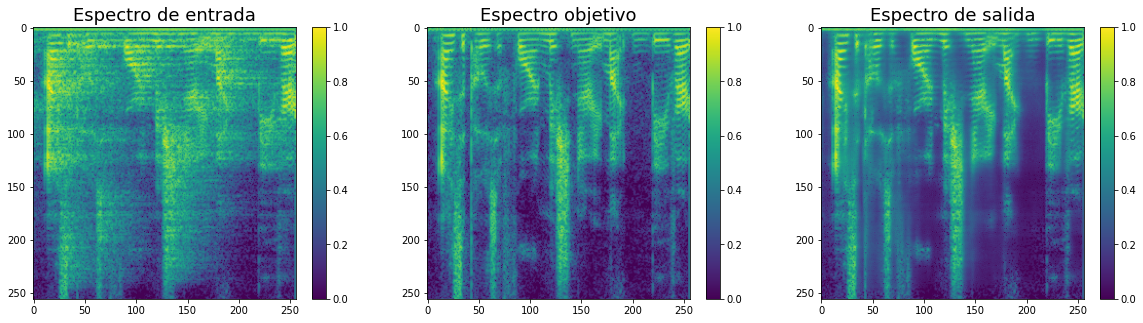

In [14]:
plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
plt.imshow(espectro_in, aspect='auto');plt.colorbar()
plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
plt.imshow(espectro_target, aspect='auto');plt.colorbar()
plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
plt.imshow(espectro_out, aspect='auto');plt.colorbar()
plt.savefig('funcionamiento.png')

In [15]:
audio_out = frame_to_raw(espectro_out, arr_min, arr_max)
audio_target = frame_to_raw(espectro_target, arr_mint, arr_maxt)

In [16]:
print('Audio con reverb (entrada)')
IPython.display.display(IPython.display.Audio(audio_in, rate=fs))
print('Audio anecoico (objetivo)')
IPython.display.display(IPython.display.Audio(audio_target, rate=fs))
print('Audio dereverberado (resultado)')
IPython.display.display(IPython.display.Audio(audio_out, rate=fs))

Audio con reverb (entrada)


Audio anecoico (objetivo)


Audio dereverberado (resultado)


# Ploteo por epocas

2021-08-27 15:17:09.733957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-27 15:17:09.750385: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199980000 Hz
2021-08-27 15:17:09.948574: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-27 15:17:10.217489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-08-27 15:17:10.482364: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-08-27 15:17:10.482390: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-08-27 15:17:10.482920: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-08-27 15:17:10.482965: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

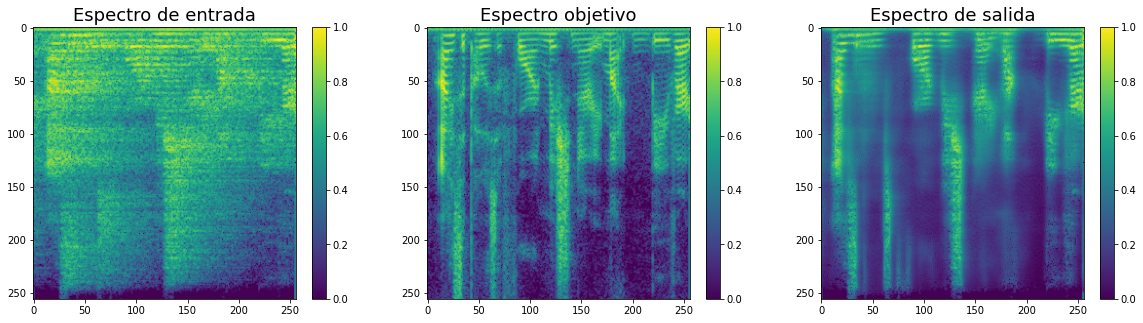

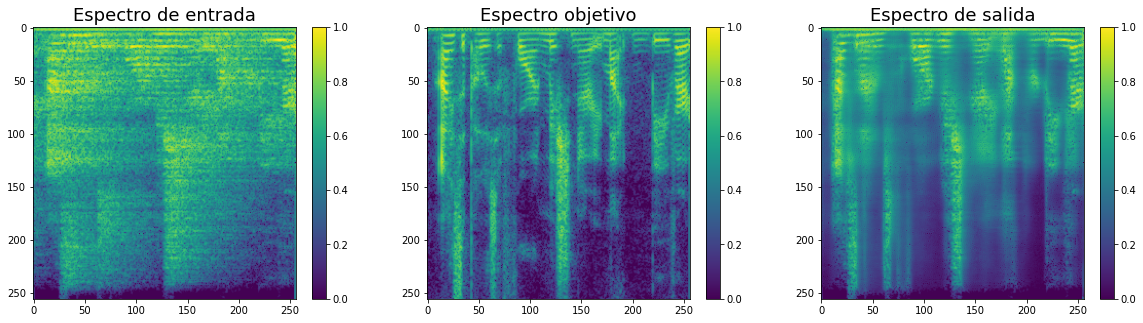

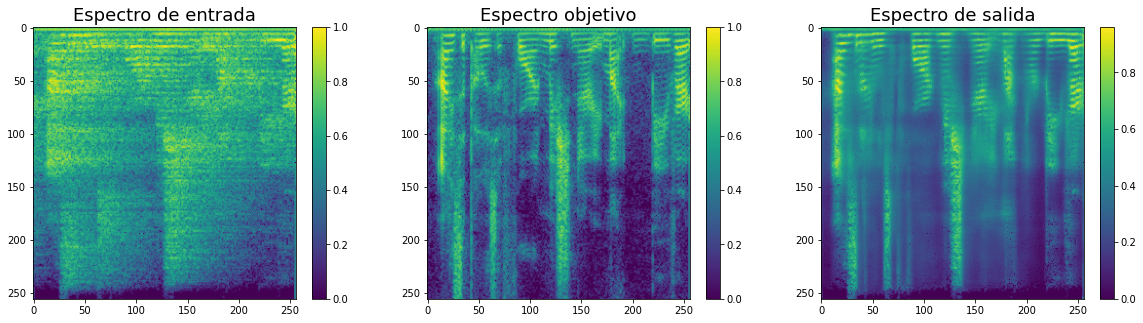

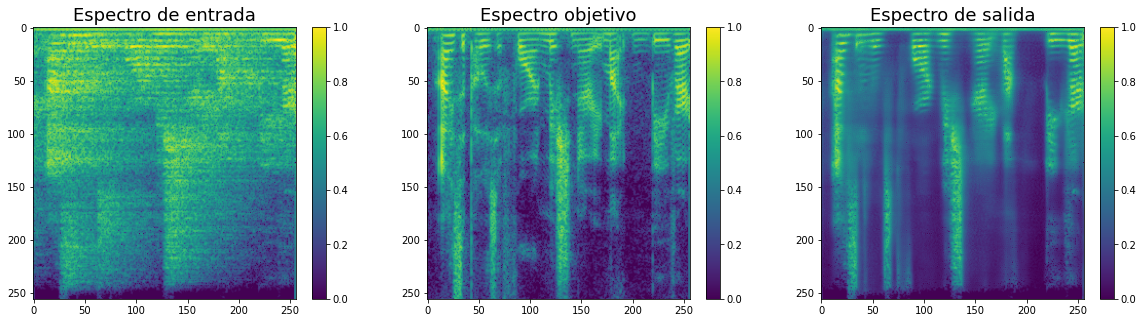

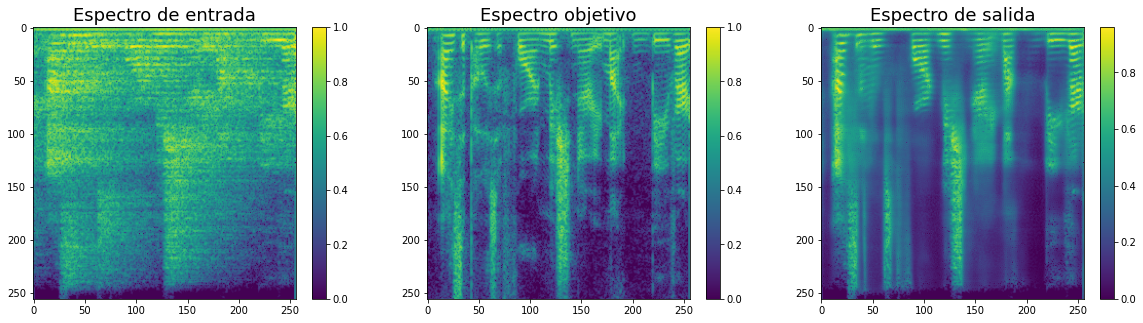

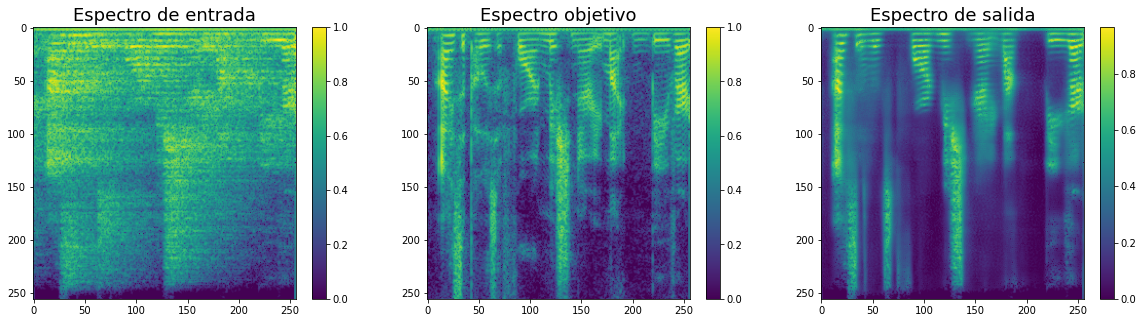

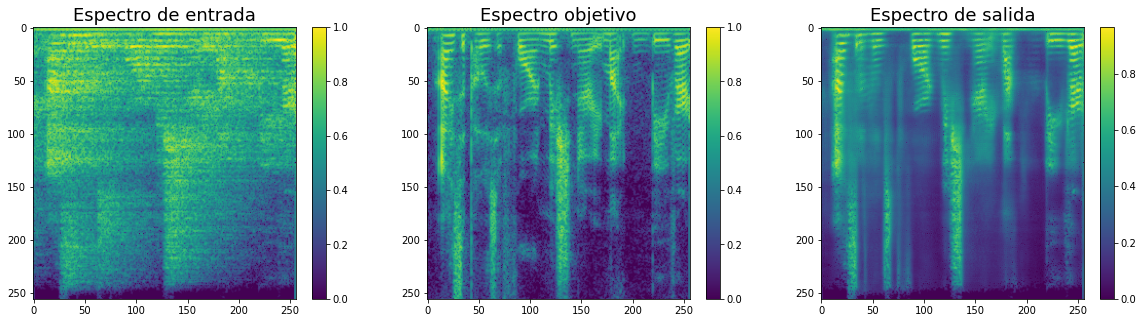

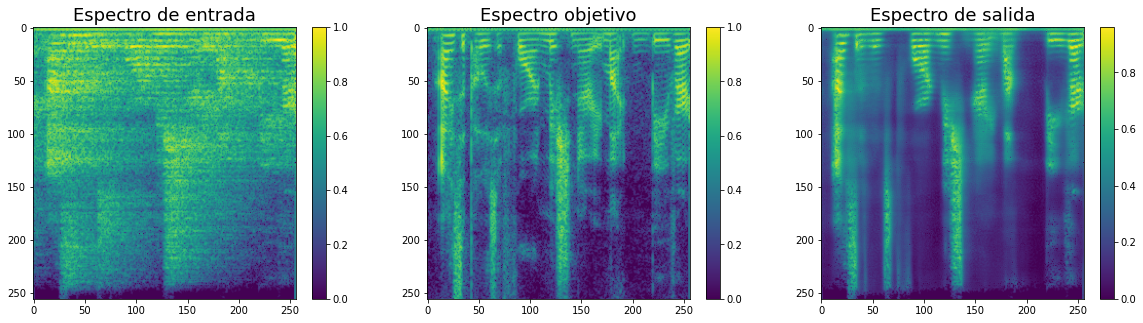

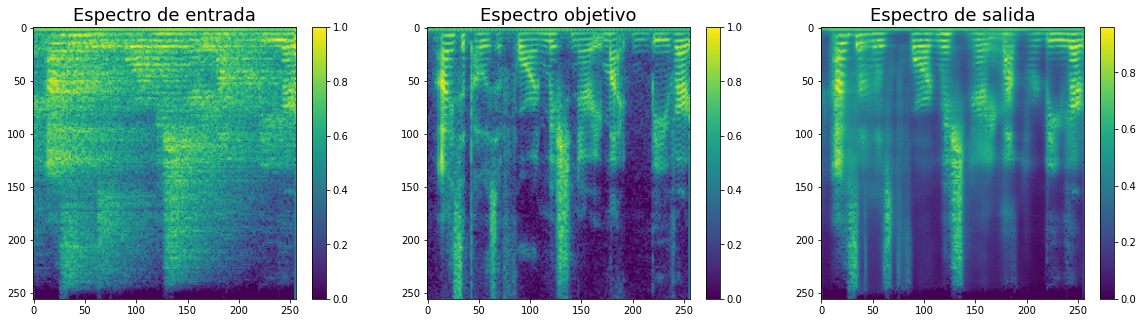

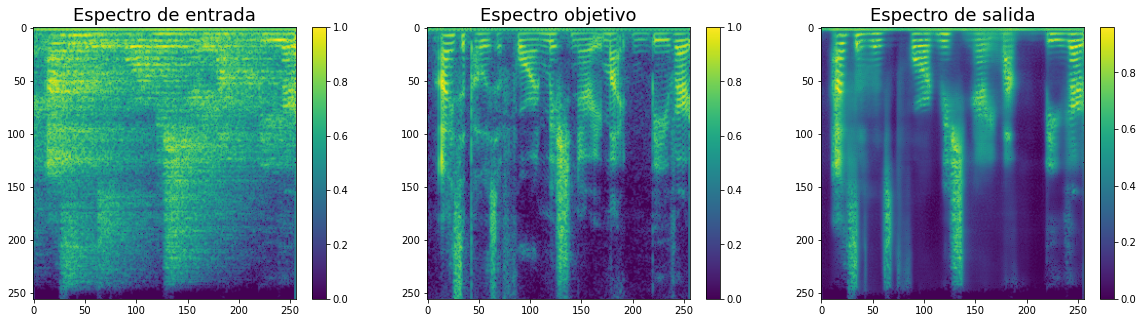

In [13]:
import glob
CARPETA = '/home/martin/deep-dereverb/model/ckpts/reales/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
labels = ['Epoca '+p.split('/')[-1].split('.')[1][:2] for p in pesos]

modelo = autoencoder()
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/train/real/')
clean_list = get_audio_list('/home/martin/deep-dereverb/data/train/clean/')
reverb_list.sort(); clean_list.sort()

for idx,peso in enumerate(pesos):
    modelo.load_weights(peso)
    audio_in, fs = librosa.load(reverb_list[570], sr=None)
    audio_target, fs = librosa.load(clean_list[570], sr=None)
    
    espectro_in, arr_min, arr_max = gen_stft(audio_in)
    espectro_target, arr_mint, arr_maxt = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    plt.figure(idx, figsize=(20,5))
    plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
    plt.imshow(espectro_in, aspect='auto');plt.colorbar()
    plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
    plt.imshow(espectro_target, aspect='auto');plt.colorbar()
    plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
    plt.imshow(espectro_out, aspect='auto');plt.colorbar()
    plt.savefig('funcionamiento.png')
    

In [41]:
def predict_model(data, modelo):                                                                                                             
  output = [layer.name for layer in modelo.layers]                                                                                           
  outputs = []                                                                                                                               
  output_names = []                                                                                                                          
  inputs = []                                                                                                                                
  input_names = []                                                                                                                           
  for layer in modelo.layers:                                                                                                                
      if hasattr(layer,'is_placeholder'):                                                                                                    
          inputs.append(layer.output)                                                                                                        
          input_names.append(layer.name)                                                                                                     
      elif layer.name in output:                                                                                                             
          outputs.append(layer.output)                                                                                                       
          output_names.append(layer.name)                                                                                                    
      else:                                                                                                                                  
          pass                                                                                                                               
  predict_fn = tf.keras.backend.function(inputs = inputs,outputs=outputs)                                                                    
  activations = predict_fn(data)                                                                                                             
  activations = {name: act for name, act in zip(output_names,activations)}                                                                   
  print('orden de las entradas: /\n',input_names)                                                                                            
  return activations 

actvs = predict_model([espectro_in.reshape(1,256,256)], modelo)

orden de las entradas: /
 ['Entrada_reverb']


In [44]:
actvs.keys()

dict_keys(['tf.expand_dims', 'CONV1', 'ACT1', 'CONV2', 'BATCH2', 'ACT2', 'CONV3', 'BATCH3', 'ACT3', 'CONV4', 'BATCH4', 'ACT4', 'CONV5', 'BATCH5', 'ACT5', 'CONV6', 'BATCH6', 'ACT6', 'CONV7', 'BATCH7', 'ACT7', 'CONV8', 'BATCH8', 're_lu', 'up_sampling2d', 'CONV9', 'BATCH9', 'dropout', 're_lu_1', 'add', 'up_sampling2d_1', 'CONV10', 'BATCH10', 'dropout_1', 're_lu_2', 'add_1', 'up_sampling2d_2', 'CONV11', 'BATCH11', 'dropout_2', 're_lu_3', 'add_2', 'up_sampling2d_3', 'CONV12', 'BATCH12', 're_lu_4', 'add_3', 'up_sampling2d_4', 'CONV13', 'BATCH13', 're_lu_5', 'add_4', 'up_sampling2d_5', 'CONV14', 'BATCH14', 're_lu_6', 'add_5', 'up_sampling2d_6', 'CONV15', 'BATCH15', 're_lu_7', 'add_6', 'up_sampling2d_7', 'SALIDA_DEL_DECODER', 're_lu_8', 'CLEAN_PREDICT'])

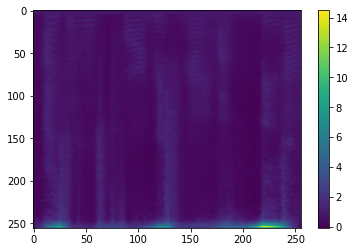

In [49]:
plt.imshow(actvs['SALIDA_DEL_DECODER'][0,:,:,0], aspect='auto')
plt.colorbar()

# Evaluacion de metricas